In [1]:
import numpy as np
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh 
import sys
import torch
import torch.nn as nn

def parse_skipgram(fname):
    with open(fname) as f:
        toks = list(f.read().split())
    nb_nodes = int(toks[0])
    nb_features = int(toks[1])
    ret = np.empty((nb_nodes, nb_features))
    it = 2
    for i in range(nb_nodes):
        cur_nd = int(toks[it]) - 1
        it += 1
        for j in range(nb_features):
            cur_ft = float(toks[it])
            ret[cur_nd][j] = cur_ft
            it += 1
    return ret

# Process a (subset of) a TU dataset into standard form
def process_tu(data, nb_nodes):
    nb_graphs = len(data)
    ft_size = data.num_features

    features = np.zeros((nb_graphs, nb_nodes, ft_size))
    adjacency = np.zeros((nb_graphs, nb_nodes, nb_nodes))
    labels = np.zeros(nb_graphs)
    sizes = np.zeros(nb_graphs, dtype=np.int32)
    masks = np.zeros((nb_graphs, nb_nodes))
       
    for g in range(nb_graphs):
        sizes[g] = data[g].x.shape[0]
        features[g, :sizes[g]] = data[g].x
        labels[g] = data[g].y[0]
        masks[g, :sizes[g]] = 1.0
        e_ind = data[g].edge_index
        coo = sp.coo_matrix((np.ones(e_ind.shape[1]), (e_ind[0, :], e_ind[1, :])), shape=(nb_nodes, nb_nodes))
        adjacency[g] = coo.todense()

    return features, adjacency, labels, sizes, masks

def micro_f1(logits, labels):
    # Compute predictions
    preds = torch.round(nn.Sigmoid()(logits))
    
    # Cast to avoid trouble
    preds = preds.long()
    labels = labels.long()

    # Count true positives, true negatives, false positives, false negatives
    tp = torch.nonzero(preds * labels).shape[0] * 1.0
    tn = torch.nonzero((preds - 1) * (labels - 1)).shape[0] * 1.0
    fp = torch.nonzero(preds * (labels - 1)).shape[0] * 1.0
    fn = torch.nonzero((preds - 1) * labels).shape[0] * 1.0

    # Compute micro-f1 score
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = (2 * prec * rec) / (prec + rec)
    return f1

"""
 Prepare adjacency matrix by expanding up to a given neighbourhood.
 This will insert loops on every node.
 Finally, the matrix is converted to bias vectors.
 Expected shape: [graph, nodes, nodes]
"""
def adj_to_bias(adj, sizes, nhood=1):
    nb_graphs = adj.shape[0]
    mt = np.empty(adj.shape)
    for g in range(nb_graphs):
        mt[g] = np.eye(adj.shape[1])
        for _ in range(nhood):
            mt[g] = np.matmul(mt[g], (adj[g] + np.eye(adj.shape[1])))
        for i in range(sizes[g]):
            for j in range(sizes[g]):
                if mt[g][i][j] > 0.0:
                    mt[g][i][j] = 1.0
    return -1e9 * (1.0 - mt)


###############################################
# This section of code adapted from tkipf/gcn #
###############################################

def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

def load_data(dataset_str): # {'pubmed', 'citeseer', 'cora'}
    """Load data."""
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("../data/Planetoid/Cora/raw/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("../data/Planetoid/Cora/raw/ind.{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset_str == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    idx_test = test_idx_range.tolist()
    idx_train = range(len(y))
    idx_val = range(len(y), len(y)+500)

    return adj, features, labels, idx_train, idx_val, idx_test

def sparse_to_tuple(sparse_mx, insert_batch=False):
    """Convert sparse matrix to tuple representation."""
    """Set insert_batch=True if you want to insert a batch dimension."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        if insert_batch:
            coords = np.vstack((np.zeros(mx.row.shape[0]), mx.row, mx.col)).transpose()
            values = mx.data
            shape = (1,) + mx.shape
        else:
            coords = np.vstack((mx.row, mx.col)).transpose()
            values = mx.data
            shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx

def standardize_data(f, train_mask):
    """Standardize feature matrix and convert to tuple representation"""
    # standardize data
    f = f.todense()
    mu = f[train_mask == True, :].mean(axis=0)
    sigma = f[train_mask == True, :].std(axis=0)
    f = f[:, np.squeeze(np.array(sigma > 0))]
    mu = f[train_mask == True, :].mean(axis=0)
    sigma = f[train_mask == True, :].std(axis=0)
    f = (f - mu) / sigma
    return f

def preprocess_features(features):
    """Row-normalize feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features.todense(), sparse_to_tuple(features)

def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [2]:
class Discriminator(nn.Module):
    def __init__(self, n_h):
        super(Discriminator, self).__init__()
        self.bilinear = nn.Bilinear(n_h, n_h, 1)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            torch.nn.init.xavier_uniform_(m.weight.data)


    def forward(self, s, pos_H, neg_H):
        summary = torch.unsqueeze(s, 1)
        summary = summary.expand_as(pos_H)

        pos_score = torch.squeeze(self.bilinear(pos_H, summary), 2)
        neg_score = torch.squeeze(self.bilinear(neg_H, summary), 2)

        logits = torch.cat((pos_score, neg_score), 1)

        return logits

In [3]:
class GCN(nn.Module):
    def __init__(self, in_ft, out_ft):
        super(GCN, self).__init__()
        self.fc = nn.Linear(in_ft, out_ft)
        self.prelu = nn.PReLU() 

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)

    def forward(self, X, adj):
        X_fts = self.fc(X)
        out = torch.unsqueeze(torch.spmm(adj, torch.squeeze(X_fts, 0)), 0)

        return self.prelu(out)

In [4]:
class AvgReadout(nn.Module):
    def __init__(self):
        super(AvgReadout, self).__init__()

    def forward(self, pth_rep):
            '''pth_rep: patch_representation'''
            return torch.mean(pth_rep, 1)

In [5]:
class DGI(nn.Module):
    def __init__(self, n_in, n_h):
        super(DGI, self).__init__()
        self.gcn = GCN(n_in, n_h)
        self.read = AvgReadout()
        self.sigm = nn.Sigmoid()
        self.disc = Discriminator(n_h)

    def forward(self, pos, neg, adj):
        pos_H = self.gcn(pos, adj)
        s = self.read(pos_H)
        s = self.sigm(s)
        neg_H = self.gcn(neg, adj)
        logits = self.disc(s, pos_H, neg_H)

        return logits

    def embed(self, seq, adj):
        pos_H = self.gcn(seq, adj)
        s = self.read(pos_H)

        return pos_H.detach(), s.detach()

In [6]:
class LogReg(nn.Module):
    def __init__(self, ft_in, nb_classes):
        super(LogReg, self).__init__()
        self.fc = nn.Linear(ft_in, nb_classes)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)

    def forward(self, feature):
        return self.fc(feature)

In [16]:
dataset = 'cora'

# training params
batch_size = 1
nb_epochs = 100
patience = 20
lr = 0.001
l2_coef = 0.0
drop_prob = 0.0
hid_units = 512

adj, features, labels, idx_train, idx_val, idx_test = load_data(dataset)
features, _ = preprocess_features(features)

nb_nodes = features.shape[0]
ft_size = features.shape[1]
nb_classes = labels.shape[1]

adj = normalize_adj(adj + sp.eye(adj.shape[0]))

sp_adj = sparse_mx_to_torch_sparse_tensor(adj)

features = torch.FloatTensor(features[np.newaxis])
labels = torch.FloatTensor(labels[np.newaxis])
idx_train = torch.LongTensor(idx_train)
idx_val = torch.LongTensor(idx_val)
idx_test = torch.LongTensor(idx_test)

model = DGI(ft_size, hid_units)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_coef)
loss_list = []
b_xent = nn.BCEWithLogitsLoss()
xent = nn.CrossEntropyLoss()
cnt_wait = 0
best = 1e9
best_t = 0

for epoch in range(nb_epochs):
    model.train()
    optimizer.zero_grad()

    idx = np.random.permutation(nb_nodes)
    shuf_fts = features[:, idx, :]

    lbl_1 = torch.ones(batch_size, nb_nodes)
    lbl_2 = torch.zeros(batch_size, nb_nodes)
    lbl = torch.cat((lbl_1, lbl_2), 1)

    logits = model(features, shuf_fts, sp_adj) 

    loss = b_xent(logits, lbl)
    loss_list.append(loss.detach().numpy())
    print('Loss:', loss)

    if loss < best:
        best = loss
        best_t = epoch
        cnt_wait = 0
        torch.save(model.state_dict(), 'best_dgi.pkl')
    else:
        cnt_wait += 1

    if cnt_wait == patience:
        print('Early stopping!')
        break

    loss.backward()
    optimizer.step()

print('Loading {}th epoch'.format(best_t))
model.load_state_dict(torch.load('best_dgi.pkl'))

embeds, _ = model.embed(features, sp_adj)
train_embs = embeds[0, idx_train]
val_embs = embeds[0, idx_val]
test_embs = embeds[0, idx_test]

train_lbls = torch.argmax(labels[0, idx_train], dim=1)
val_lbls = torch.argmax(labels[0, idx_val], dim=1)
test_lbls = torch.argmax(labels[0, idx_test], dim=1)

tot = torch.zeros(1)



/var/folders/y7/4dj88c7s275b9kknhqkqf4s80000gn/T/ipykernel_50087/1527594678.py:112: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  objects.append(pkl.load(f, encoding='latin1'))


Loss: tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.7596, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6921, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.7351, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.7234, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6982, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6912, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6972, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.7022, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.7009, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6957, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6912, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6905, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6932, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6935,

In [31]:
accs = []

loss_list2 = []
log = LogReg(hid_units, nb_classes)
opt = torch.optim.Adam(log.parameters(), lr=0.01, weight_decay=0.0)
pat_steps = 0
best_acc = torch.zeros(1)
for _ in range(200):
    log.train()
    opt.zero_grad()

    logits = log(train_embs)
    loss = xent(logits, train_lbls)
    loss_list2.append(loss.detach().numpy())
    loss.backward()
    opt.step()

logits = log(test_embs)
preds = torch.argmax(logits, dim=1)
acc = torch.sum(preds == test_lbls).float() / test_lbls.shape[0]
accs.append(acc * 100)
print(acc)
tot += acc

print('Average accuracy:', tot / 50)

accs = torch.stack(accs)
print(accs.mean())
print(accs.std())

tensor(0.8120)
Average accuracy: tensor([2.4766])
tensor(81.2000)
tensor(nan)


In [14]:
len(loss_list)

100

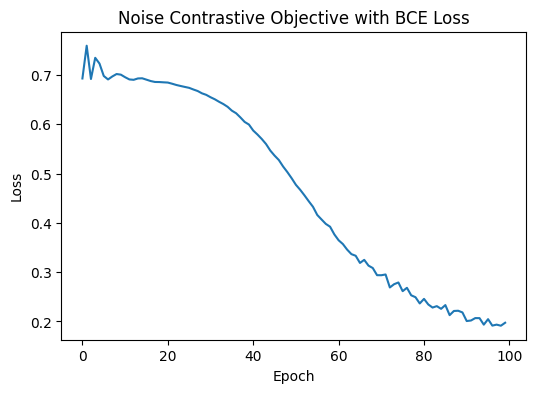

In [32]:
import matplotlib.pyplot as plt
epochs = list(range(0, 100)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, loss_list)

plt.title('Noise Contrastive Objective with BCE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


# 그리드 표시

# 그래프 표시
plt.show()


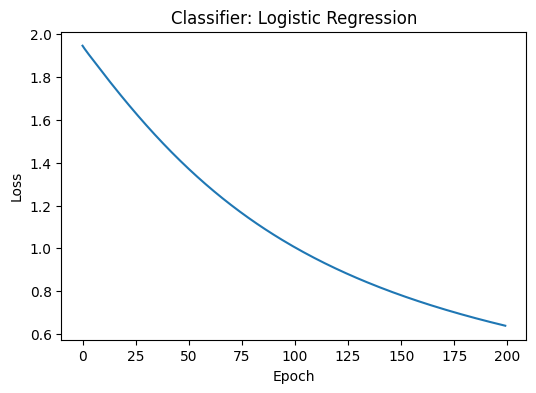

In [33]:
epochs = list(range(200)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, loss_list2)

plt.title('Classifier: Logistic Regression')
plt.xlabel('Epoch')
plt.ylabel('Loss')


# 그리드 표시

# 그래프 표시
plt.show()
